LIME For BCW Explanation
-

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import random
import warnings

from lime import lime_tabular
import lime

warnings.filterwarnings("ignore")

import time
import numpy as np
import math
from collections import deque
import random
import heapq
import tensorflow as tf

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

breast_cancer = load_breast_cancer()

for line in breast_cancer.DESCR.split("\n")[5:32]:
    print(line)

X, Y = breast_cancer.data, breast_cancer.target

print("Data Size : ", X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, test_size=0.1, stratify=Y, random_state=123)

print("Train/Test Sizes : ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

lr = LogisticRegression()

lr.fit(X_train, Y_train)

print("Test  Accuracy : %.2f"%lr.score(X_test, Y_test))
print("Train Accuracy : %.2f"%lr.score(X_train, Y_train))
print()
print("Confusion Matrix : ")
print(confusion_matrix(Y_test, lr.predict(X_test)))
print()
print("Classification Report")
print(classification_report(Y_test, lr.predict(X_test)))

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radius, field
        10 is Radius SE, field 20 is Worst Radius.

        - class:
                - WDBC-Malignant
       

In [3]:
explainer = lime_tabular.LimeTabularExplainer(X_train, mode="classification",
                                              class_names=breast_cancer.target_names,
                                              feature_names=breast_cancer.feature_names,
                                             )

In [4]:
random.seed(0)
idx = random.randint(1, len(X_test))

print("Prediction : ", breast_cancer.target_names[lr.predict(X_test[idx].reshape(1,-1))[0]])
print("Actual :     ", breast_cancer.target_names[Y_test[idx]])

start_time = time.time()
explanation = explainer.explain_instance(X_test[idx], lr.predict_proba,
                                         num_features=len(breast_cancer.feature_names))

print("LIME Explaination Time:",time.time() - start_time)
explanation.show_in_notebook()

Prediction :  malignant
Actual :      malignant
LIME Explaination Time: 13.720491886138916


In [5]:
explanation.as_map()

{1: [(23, -0.5156615805797008),
  (22, -0.41436854243891363),
  (20, 0.293705839431655),
  (13, -0.2560181273027456),
  (0, 0.22204656367626543),
  (2, 0.10801909348073971),
  (3, -0.05107427471322372),
  (21, 0.035638414908168256),
  (10, -0.024153768974780828),
  (11, -0.01841119828075161),
  (12, -0.016759199780281273),
  (6, 0.01595993801835324),
  (19, 0.013970318046741391),
  (25, -0.013552570705465474),
  (4, -0.012744712787089694),
  (8, -0.012503804252167412),
  (18, -0.011405385193844717),
  (28, -0.008744826670844941),
  (24, -0.0074481728754708845),
  (17, -0.007274022249340606),
  (5, 0.0067324850965329265),
  (16, -0.0053463720057489),
  (9, 0.004952616511330793),
  (27, 0.0044493264026174715),
  (15, 0.003820376609382857),
  (14, -0.003218015531806046),
  (7, 0.0030998837665403827),
  (29, -0.002980909831979747),
  (26, 0.0012692025549729616),
  (1, 0.0009590411022189509)]}

In [6]:
print("Input : ", X_test[idx])
print("Output :     ",Y_test[idx])

Input :  [1.799e+01 2.066e+01 1.178e+02 9.917e+02 1.036e-01 1.304e-01 1.201e-01
 8.824e-02 1.992e-01 6.069e-02 4.537e-01 8.733e-01 3.061e+00 4.981e+01
 7.231e-03 2.772e-02 2.509e-02 1.480e-02 1.414e-02 3.336e-03 2.108e+01
 2.541e+01 1.381e+02 1.349e+03 1.482e-01 3.735e-01 3.301e-01 1.974e-01
 3.060e-01 8.503e-02]
Output :      0


---

DFEST BCW Explanation
-

In [7]:
#Dependencies
import sys
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import time
import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
import numpy as np
import math
from collections import deque
import random
import heapq
import scipy

Define Structure of Feature Space as a Graph
-

In [8]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

Calculate Feature-Interaction Cluster
-

In [9]:
# Puts solution node into a n-way feature interaction cluster, and tell which cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler):
    
    #print("query_node1",query_node.position, "source_node1",source_node.position)
    soln_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
                
    if tuple(soln_cluster) not in solution_clusters:
        solution_clusters[tuple(soln_cluster)] = []

    solution_clusters[tuple(soln_cluster)].append(query_node.position)
    
    return solution_clusters #returns full cluster list


def calc_feat_cluster(source_node, query_node, feat_scaler):
    
    relative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (relative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                soln_cluster[f_i] = 1
            else:
                soln_cluster[f_i] = -1
    
    if scaled_feats[f_max] > 0:
        soln_cluster[f_max] = 1
    else:
        soln_cluster[f_max] = -1
        
    return soln_cluster.astype(int)

Generate Uniform Distribution of Unit Vectors in d-dimensional space
---

In [10]:
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        #v_hat = v / np.linalg.norm(v)
        vectors.append(v)
    return vectors

Find k-way Feature-Interaction Solutions Surrounding Source Node
---

In [11]:
def generate_precursor_solutions(source_node, feat_ranges, model, k_prelim=1000, nsteps=100):
    
    #plt.rcParams["figure.figsize"] = (10,10)
    
    feat_ranges = feat_ranges #Ground truth altered boundary of solutions
    #feat_range = feat_ranges[0] #debug: gti can't dynamically scale feat proportions
    #feat_upscale = len(source_node.position)*5
    #step_sizes = (feat_upscale*feat_ranges/nsteps) #How large of a step to take for each respective int feature
    step_sizes = (feat_ranges/nsteps)
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.linspace(step_sizes[feat],step_sizes[feat]*nsteps,nsteps))
    feat_steps = np.asarray(feat_steps)
    
    #print("feat_steps",feat_steps)
    
    source_rec = query_model(model, source_node)

    discovered = []

    while len(discovered) < k_prelim:
        
        #print("###########################################################################")
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        unit_vector = np.sign(np.round(unit_vector)) #Scale randomly generated clusters by appropriate ratio
        for step in range(nsteps-1):
            scaled_vector_position = np.asarray(tuple(np.asarray(unit_vector) * np.asarray(feat_steps.T[step]) + np.asarray(source_node.position)))
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_model(model, scaled_vector)
            
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'bd',markersize=10)
            
            if source_rec != query_rec:
                # distance heuristic
                #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'r^',markersize=15)
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                if len(discovered) % 1000 == 0:
                    print(len(discovered),end=' ')
                break
                
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
        
    return discovered #prelim_discovered

In [12]:
def generate_1way_precursor_solutions(source_node, feat_ranges, model, k_prelim=1000, nsteps=100):

    step_sizes = (feat_ranges/nsteps)
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance

    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.linspace(step_sizes[feat],step_sizes[feat]*nsteps,nsteps))
    feat_steps = np.asarray(feat_steps)

    #print("feat_steps",feat_steps)

    source_rec = query_model(model, source_node)

    discovered = []

    #1 way interactions only
    cluster_vectors = []
    for feat in range(len(feat_ranges)):
        base_vector = np.zeros(len(feat_ranges))
        addition_vector = base_vector.copy()
        addition_vector[feat] = 1
        subraction_vector = base_vector.copy()
        subraction_vector[feat] = -1
        cluster_vectors.append(addition_vector)
        cluster_vectors.append(subraction_vector)

    for cluster_vector in cluster_vectors:

        for step in range(nsteps-1):
            scaled_vector_position = np.asarray(tuple(np.asarray(cluster_vector) * np.asarray(feat_steps.T[step]) + np.asarray(source_node.position)))
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_model(model, scaled_vector)

            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'bd',markersize=10)

            if source_rec != query_rec:
                # distance heuristic
                #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'r^',markersize=15)
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                if len(discovered) % 100 == 0:
                    print(len(discovered),end=' ')
                break
                
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
        
    return discovered #prelim_discovered

Calculate Distance from Source to Query Node
---

In [13]:
def get_distance(source_node, query_node, feat_scaler, distance='Euclidean'):
    #returns normalized distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = dif * feat_scaler
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

Display Shortest Clusters Found During Outside-In Search
-

In [14]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

Adjacent Cluster Search
-

In [15]:
#Return positions in adjacent solution clusters
def find_adjs(source_node, query_node, feat_scaler):
    
    query_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    query_cluster = list(query_cluster)
    adj_clusters = []

    #1-way changes are applied to each feature in the query cluster to generate adj clusters
    source_cluster = tuple(np.zeros(len(query_cluster)))
    for dim in range(len(query_cluster)):
        temp = query_cluster.copy()
        if temp[dim] < 1:
            temp[dim] += 1
            if temp != source_cluster:
                adj_clusters.append(temp)
        temp = query_cluster.copy()
        if temp[dim] > -1:
            temp[dim] -= 1
            if temp != source_cluster:
                adj_clusters.append(temp)

    #Normalization to find x_q
    feat_scaler_distance = 0
    for feat in feat_scaler:
        feat_scaler_distance += feat ** 2
    feat_scaler_distance = feat_scaler_distance ** 0.5
        
    adjs = []
    for cluster in adj_clusters:
        
        # n-dimensional euclidean distance to a point in the adj cluster equivalent to the distance
        # from the original query cluster
        # query_node.distance is pre-scaled scaled
        x_q = source_node.position + feat_scaler * np.asarray(cluster) * query_node.distance / feat_scaler_distance
        adj_node = Node(np.asarray(x_q), query_node.distance)
        adjs.append(adj_node)
        
    return adjs  

Informed Cluster Search
-

In [16]:
#A* with solution cluster tracking

#A* cluster Search
def a_star_search(source_node, prelim_discovered, feat_ranges, model, k_astar=1000):
    
    #Analytics to inform how to handle degree of branching
    #feat_range = feat_ranges[0] #Can't yet use multiple ranges for defining gti
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = {} #Map of clusters to their minimum node 
    solution_clusters = {} #Dict of of k-closest feature interactions to opposite recommendation
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    #Opposite Recommendation as Solutions
    source_rec = query_model(model, source_node)
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k_astar:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check if query node is a solution
        query_rec = query_model(model, query_node)
        if query_rec != source_rec:
            
            feat_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
            
            if tuple(feat_cluster) not in solution_clusters.keys():
                
                #Finds shortest distance node in cluster, returns solution_clusters with descending solutions
                solution_clusters, min_node = find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, model)
                discovered[tuple(feat_cluster)] = min_node #redundant list
                if len(discovered) % 100 == 0:
                    print(len(discovered),end=' ')
                
                #Add adjacents to priority queue before visiting them
                adjs = find_adjs(source_node, min_node, feat_scaler) #Nodes in clusters adjacent to the current node
                for adj_node in adjs:
                    heapq.heappush(frontier, adj_node)
                    nodes_generated += 1
    
    print("\nNodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)

    return solution_clusters, discovered


################################################################################

Cluster Minimum
-

In [17]:
#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, model, nsteps=100):
    
    plt.rcParams["figure.figsize"] = (10, 10)
    relative_pos = query_node.position - source_node.position
    step_sizes = (relative_pos/nsteps) #How large of a step to take for each respective int feature

    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        if step_sizes[feat] != 0:
            feat_steps.append(np.linspace(step_sizes[feat],relative_pos[feat],nsteps))
        else:
            feat_steps.append(np.zeros(nsteps))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps)    

    source_rec = query_model(model, source_node)
    query_rec = query_model(model, query_node)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    min_node = query_node
    for step in range(nsteps-1):
        
        local_feat_step = []
        for feat in range(len(feat_steps)):
            local_feat_step.append(feat_steps[feat][step])
        scaled_vector_position = np.asarray(tuple(np.asarray(query_node.position) - np.asarray(local_feat_step)))
        #scaled_vector_position = np.asarray(source_node.position + local_feat_step)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_model(model, scaled_vector)
        
        if source_rec == query_rec:
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'g*',markersize=15)
            break
            
        scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
        min_node = scaled_vector
        solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
        #print(min_node.position,end='')

        #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'m+',markersize=10)
        
    #print(calc_feat_cluster(source_node, min_node, feat_scaler))
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=30)

    return solution_clusters, min_node

Prepare BCW Data for DFEST
-

In [18]:
def get_domain(X):
    
    domain = []
    for i in range(len(X.T)):
        dif = max(X.T[i]) - min(X.T[i])
        domain.append(dif)
    return domain

domain = get_domain(X)

x_s = X_test[idx]
n_dims = x_s.shape[0] #Number of features in BCW input data
source_node = Node(x_s,0) #Want to explain the output of this input
k_clusters = 8 #Number of top feature-interactions to return

feat_ranges = np.asarray(domain) #Assume all features have range 1000
feat_scaler = 1 / feat_ranges

model = lr

In [19]:
def query_model(model, node):
    x_q = node.position.reshape(1,-1)
    return model.predict(x_q)[0]

Batch Run DFEST
-

In [40]:
#Run A* against ground truth synthetic model

def dfest(source_node, feat_ranges, model, k_prelim=100000, k_astar=5000):

    plt.rcParams["figure.figsize"] = (40,15)
    
    feat_scaler = 1/np.asarray(feat_ranges)

    start_time = time.time()
    prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, model, nsteps=10, k_prelim=k_prelim)
    print("\n\nPreliminary Search Time:", time.time()-start_time,'seconds')
    
    start_time = time.time()
    solution_clusters, discovered = a_star_search(source_node, prelim_discovered, feat_ranges, model, k_astar=k_astar)
    print("\n\nInformed Cluster Search Time:", time.time()-start_time,'seconds')

    sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
    #display_instability(sorted_clusters)

    return sorted_clusters, discovered

In [41]:
sorted_clusters, discovered_dict = dfest(source_node, feat_ranges, model)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 

Preliminary Search Time: 118.73638391494751 seconds
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 
Nodes Visited: 237967
Nodes Generated: 333011


Informed Cluster Search Time: 54.2359139919281 seconds


In [42]:
ksolutions = []
k = 50
for index in range(k):
    ksolutions.append(sorted_clusters[index][1])
ksolutions = np.asarray(ksolutions)
ksolutions.shape

(50, 30)

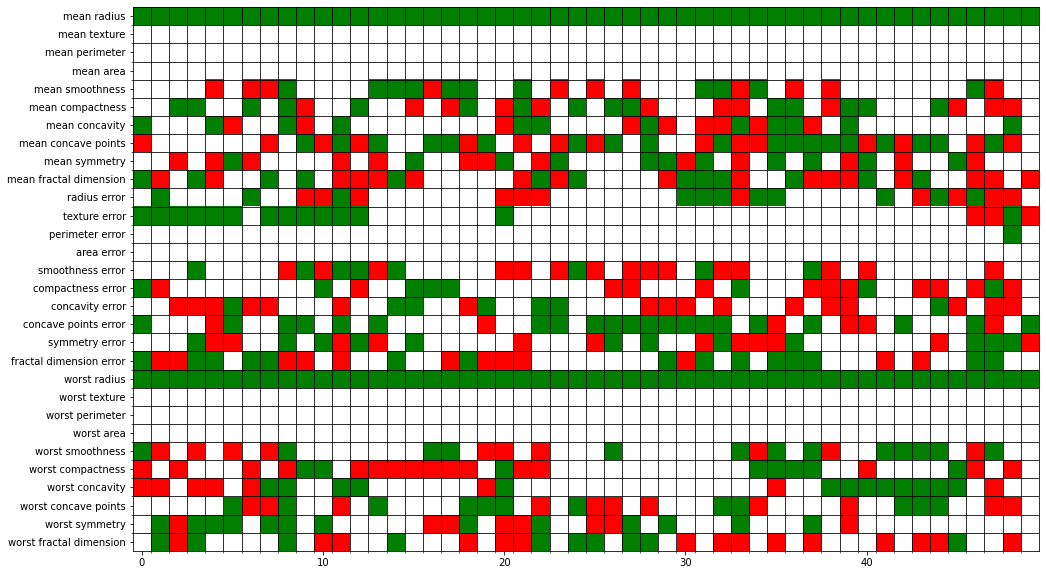

In [43]:
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
#ax.set_xticklabels(list(breast_cancer.feature_names))

nx = ksolutions.shape[1]
no_labels = ksolutions.shape[1] # how many labels to see on axis x
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
plt.yticks(x_positions, list(breast_cancer.feature_names))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

ax.set_xticks([x-0.5 for x in range(1,ksolutions.shape[0])],minor=True )
ax.set_yticks([y-0.5 for y in range(1,ksolutions.shape[1])],minor=True)
ax.grid(color='k',which='minor',axis='both')

matplotlib.pyplot.imshow(ksolutions.T,cmap=cmap)

In [44]:
ksolutions_avg = []
for feature in range(len(ksolutions.T)):
    feat_instability = ksolutions.T[feature]
    ksolutions_avg.append(np.mean(abs(feat_instability)))
ksolutions_avg = np.asarray(ksolutions_avg)

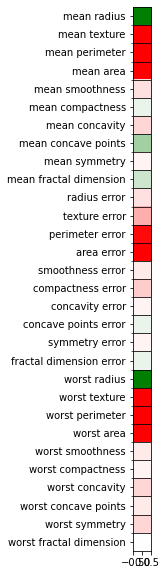

In [45]:
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
ksolutions_avg = np.expand_dims(ksolutions_avg, axis=1)

nx = ksolutions_avg.shape[0]
no_labels = ksolutions_avg.shape[0] # how many labels to see on axis x
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
plt.yticks(x_positions, list(breast_cancer.feature_names))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

ax.set_yticks([y-0.5 for y in range(1,ksolutions_avg.shape[0])],minor=True)
ax.grid(color='k',which='minor',axis='y')

matplotlib.pyplot.imshow(ksolutions_avg,cmap=cmap)

In [46]:
p = np.argsort(ksolutions_avg.T)
ksolutions_avg_sorted = np.sort(np.asarray(ksolutions_avg.T))
sorted_labels = list(breast_cancer.feature_names[p])[0]

<BarContainer object of 30 artists>

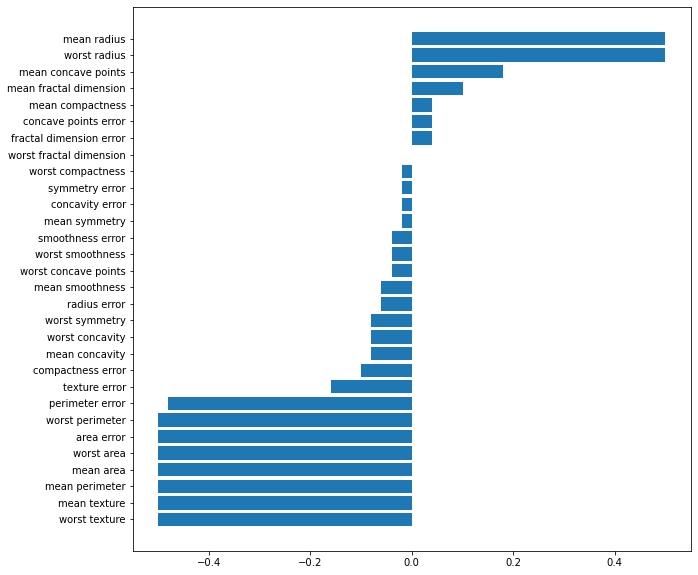

In [47]:
plt.barh(sorted_labels, list(ksolutions_avg_sorted[0] - 0.5))

<BarContainer object of 30 artists>

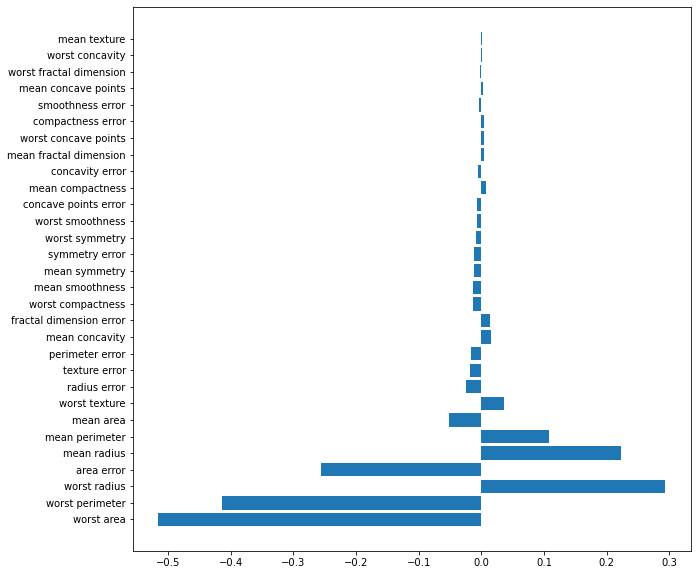

In [48]:
lime_data = []
lime_labels = []
for feature in range(len(explanation.as_map()[1])):
    lime_labels.append(explanation.as_map()[1][feature][0])
    lime_data.append(explanation.as_map()[1][feature][1])
plt.barh(breast_cancer.feature_names[lime_labels],lime_data)

Magnitude of DFEST Included
-

In [49]:
#Scaled magnitude of each f_i in each top k cluster interaction
node_ksolutions = []
for cluster in ksolutions:
    min_node = discovered_dict[tuple(cluster)]
    dif = (min_node.position - source_node.position) * cluster
    scaled_dif = (dif * feat_scaler)
    node_ksolutions.append(scaled_dif)
node_ksolutions = np.asarray(node_ksolutions)

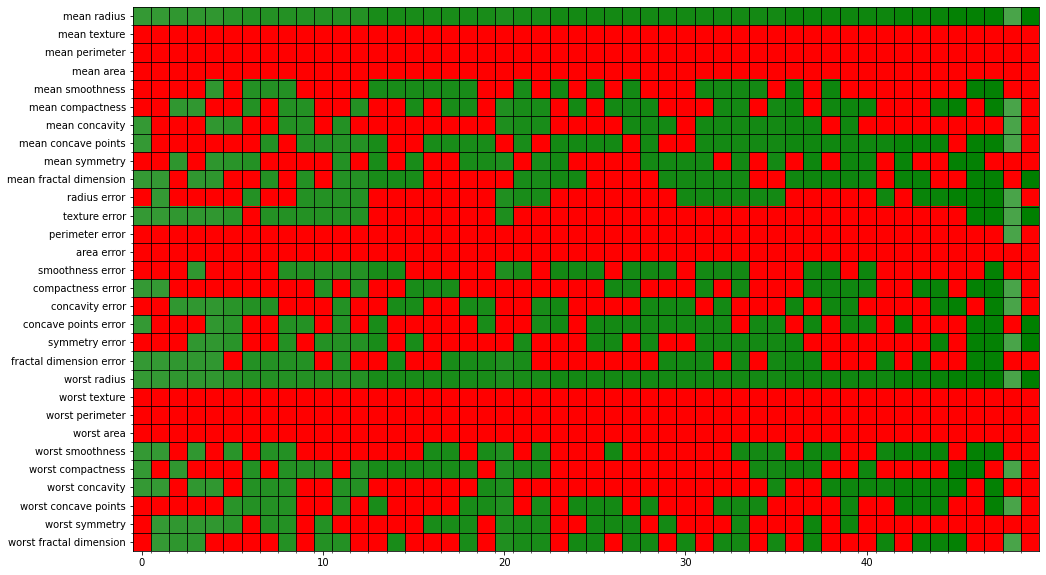

In [50]:
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
#ax.set_xticklabels(list(breast_cancer.feature_names))

nx = ksolutions.shape[1]
no_labels = node_ksolutions.shape[1] # how many labels to see on axis x
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
plt.yticks(x_positions, list(breast_cancer.feature_names))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

ax.set_xticks([x-0.5 for x in range(1,node_ksolutions.shape[0])],minor=True )
ax.set_yticks([y-0.5 for y in range(1,node_ksolutions.shape[1])],minor=True)
ax.grid(color='k',which='minor',axis='both')

matplotlib.pyplot.imshow(node_ksolutions.T,cmap=cmap)

In [65]:
node_ksolutions.T

array([[0.086, 0.086, 0.087, ..., 0.095, 0.082, 0.096],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.095, 0.082, 0.   ],
       [0.   , 0.086, 0.087, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.086, 0.087, ..., 0.   , 0.082, 0.   ]])

In [60]:
#Average to match format of LIME
node_ksolutions_avg = []
for feature in range(len(node_ksolutions.T)):
    feat_instability = node_ksolutions.T[feature]
    #node_ksolutions_avg.append(np.mean(abs(feat_instability)))
    node_ksolutions_avg.append(np.sum(feat_instability))
node_ksolutions_avg = np.asarray(node_ksolutions_avg)

In [61]:
p = np.argsort(node_ksolutions_avg.T)
node_ksolutions_avg_sorted = np.sort(np.asarray(node_ksolutions_avg.T))
sorted_labels = list(breast_cancer.feature_names[p])

<BarContainer object of 30 artists>

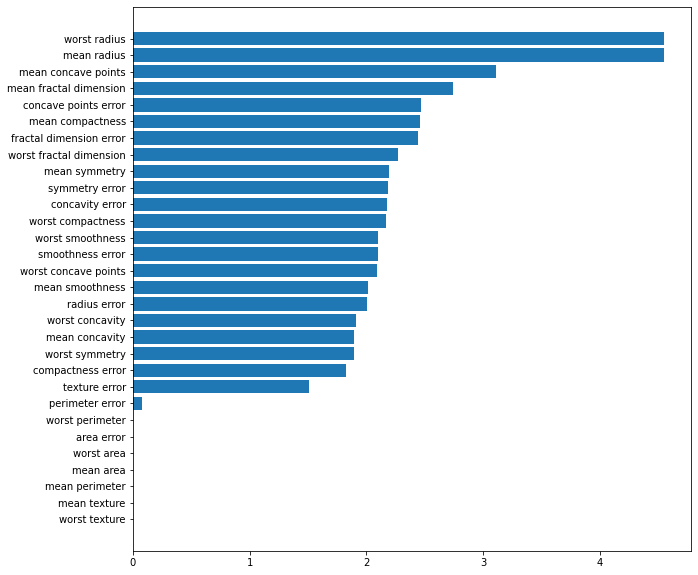

In [62]:
plt.barh(sorted_labels, node_ksolutions_avg_sorted)

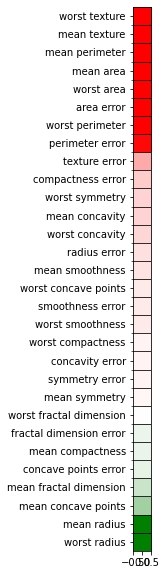

In [59]:
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
node_ksolutions_avg_sorted = np.expand_dims(node_ksolutions_avg_sorted, axis=1)

nx = node_ksolutions_avg_sorted.shape[0]
no_labels = node_ksolutions_avg_sorted.shape[0] # how many labels to see on axis x
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
plt.yticks(x_positions, list(breast_cancer.feature_names[p]))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

ax.set_yticks([y-0.5 for y in range(1,node_ksolutions_avg_sorted.shape[0])],minor=True)
ax.grid(color='k',which='minor',axis='y')

matplotlib.pyplot.imshow(node_ksolutions_avg_sorted,cmap=cmap)